# Procesamiento

In [1]:
%pip install numpy pandas opencv-python scikit-image matplotlib pillow tqdm

  Using cached tqdm-4.67.1-py3-none-any.whl.metadata (57 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 37.3/37.3 MB 1.0 MB/s eta 0:00:000:00:0100:05
Using cached tqdm-4.67.1-py3-none-any.whl (78 kB)

[notice] A new release of pip is available: 25.0 -> 25.1.1
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [2]:
import numpy as np
import pandas as pd
import cv2
import requests
from io import BytesIO
from PIL import Image
from skimage import color, feature
from concurrent.futures import ThreadPoolExecutor, as_completed
from tqdm import tqdm
import os

### Extractores de Features

Usaremos 3 tecnicas vicuales de Computer Vision para esto:

* **Histograma de color:** Los posters suelen tener diferentes paletas de colores segun el genero. La idea es que el modelo identifique esta paleta de colores. En general, captura estetica y de color general. En este caso usaremos el HSV.
* **Descriptores de textura:** Usaremos LBP (Local Binary Patterns), nos servira para detectar las texturas.
* **Hu Moments:** Lo usaremos como un extra, ya que captura la forma general de la imagen (genera 7 valores).

> NOTA: Hay extractores de features de Deep Learning, Deep Featrues con CNN. Es muy recomendado para entrenar modelos de Clustering, pero no usaremos debido a que seria un overkill del problema.

In [72]:
# Historgama de Color
def extract_hsv(img, bins=32):
    hsv = color.rgb2hsv(img)
    h = np.histogram(hsv[:, :, 0], bins=bins, range=(0, 1))[0]
    s = np.histogram(hsv[:, :, 1], bins=bins, range=(0, 1))[0]
    v = np.histogram(hsv[:, :, 2], bins=bins, range=(0, 1))[0]
    return np.concatenate([h, s, v])

# Descriptores de Textura
def extract_lbp(img, P=8, R=1):
    g = color.rgb2gray(img)
    g_uint8 = (g * 255).astype(np.uint8)
    lbp = feature.local_binary_pattern(g_uint8, P, R, method='uniform')
    n_bins = int(lbp.max() + 1)
    hist, _ = np.histogram(lbp, bins=n_bins, range=(0, n_bins), density=True)
    return hist

# Hu Moments
def extract_hu(img):
    gray = color.rgb2gray(img)
    gray_uint8 = (gray * 255).astype(np.uint8)
    moments = cv2.moments(gray_uint8)
    hu = cv2.HuMoments(moments).flatten()
    return hu

# Extractor paralelizado
def extract_all_features(img):
    with ThreadPoolExecutor(max_workers=3) as executor:
        future_hsv = executor.submit(extract_hsv, img)
        future_lbp = executor.submit(extract_lbp, img)
        future_hu = executor.submit(extract_hu, img)
        
        hsv = future_hsv.result()
        lbp = future_lbp.result()
        hu = future_hu.result()
        
        return np.concatenate([hsv, lbp, hu])

In [99]:
# Funcion de descarga de imgs
def download_img(url):
    try:
        response = requests.get(url, timeout=5)
        img = Image.open(BytesIO(response.content)).convert("RGB")
        return np.array(img)
    except Exception:
        return None

In [100]:
# Funcion de procesamiento por fila
def process_row(row, id_col, url_col):
    movie_id = row[id_col]
    url = row[url_col]
    img = download_img(url)
    if img is None:
        return None
    try:
        features = extract_all_features(img)
        return (movie_id, features)
    except Exception:
        return None

Funcion principal:

In [101]:
# Funcion principal que arma el dataset de features
def extract_features_from_dataframe(df, id, url):
    num_workers = max(1, min(32, (os.cpu_count() or 4) - 1))
    print(f"Usando {num_workers} hilos...")

    # Procesamiento de imgs en paralelo
    results = []
    with ThreadPoolExecutor(max_workers=num_workers) as executor:
        fs = [executor.submit(process_row, row, id, url) for _, row in df.iterrows()]
        for f in tqdm(as_completed(fs), total=len(fs)):
            result = f.result()
            if result:
                results.append(result)

    # Construir dataframe final
    ids = [r[0] for r in results]
    vec = [r[1] for r in results]
    features_df = pd.DataFrame(vec)
    features_df.insert(0, id, ids)

    return features_df

Lo que hace esto es revisar la cantidad de workers que puede soportar el procesador en el que se corre el codigo, y segun eso, se adapta y puede que vaya mas rapido o mas lento segun ese numero.

Ademas, extrae de forma paralela el histograma de color, los descriptores de textura y Hu Moments.

Al final devuelve un dataframe completo, indicado cual es el ID de la pelicula y los features para cada pelicula.

### Test

Usaremos las primeras 5 filas para testear el featur extraction

In [ ]:
df_test = pd.read_csv('../data/links_datasets/prim.csv')
df_test = df_test.head()
df_test

,Unnamed: 0,movieId,title,poster_url,poster_source
0,53,171751,Munna bhai M.B.B.S. (2003),https://image.tmdb.org/t/p/w185/nZNUTxGsSB4nLE...,tmdb_by_id
1,56,163527,Comedy Central Roast of David Hasselhoff (2010),https://image.tmdb.org/t/p/w185/sX66iM4rds1pkL...,tmdb_by_id
2,79,193565,Gintama: The Movie (2010),https://image.tmdb.org/t/p/w185/E3RT3f8oOuPS2p...,tmdb_by_id
3,158,180987,Ferdinand (2017),https://image.tmdb.org/t/p/w185/rMm94JsRfcOPiP...,tmdb_by_id
4,171,167746,The Lego Batman Movie (2017),https://image.tmdb.org/t/p/w185/snGwr2gag4Fcgx...,tmdb_by_id


Con esto procesaremos las columnas y sacaremos un data frame nuevo con los features extraidos por imagen

In [103]:
df_test_features = extract_features_from_dataframe(df_test, id="movieId", url="poster_url")

Usando 7 hilos...


100%|██████████| 5/5 [00:00<00:00, 11.12it/s]


In [104]:
df_test_features

,movieId,0,1,2,3,4,5,6,7,8,...,103,104,105,106,107,108,109,110,111,112
0,163527,2012.0,804.0,551.0,428.0,617.0,597.0,312.0,22.0,76.0,...,0.047521,0.536360,0.069162,0.004495,2.304067e-06,2.329233e-08,2.095254e-08,4.625556e-16,3.169477e-11,1.713062e-17
1,180987,10785.0,5957.0,3525.0,1440.0,432.0,704.0,566.0,1753.0,2599.0,...,0.072837,0.192786,0.097628,0.001415,4.090964e-07,2.197719e-10,6.446146e-11,1.591053e-21,9.775326e-15,7.505707e-21
2,171751,13524.0,901.0,2781.0,5000.0,897.0,1031.0,1017.0,772.0,1376.0,...,0.080673,0.314388,0.117811,0.000943,1.227961e-07,1.638983e-12,1.040450e-11,4.008124e-23,3.616359e-15,1.547644e-23
3,167746,867.0,596.0,1211.0,5438.0,30582.0,5160.0,466.0,270.0,244.0,...,0.083881,0.112114,0.113844,0.001146,1.797885e-07,5.756547e-12,1.725448e-11,1.355869e-22,6.577599e-15,-1.057700e-22
4,193565,4214.0,4338.0,6206.0,2427.0,1223.0,807.0,448.0,328.0,341.0,...,0.078826,0.138324,0.118569,0.001350,2.414537e-07,1.089165e-10,7.666629e-11,6.135236e-21,3.473041e-14,3.382184e-21


### prim.csv

In [108]:
prim_path = '../data/links_datasets/prim.csv'

df_prim = pd.read_csv(prim_path)
df_prim

,Unnamed: 0,movieId,title,poster_url,poster_source
0,53,171751,Munna bhai M.B.B.S. (2003),https://image.tmdb.org/t/p/w185/nZNUTxGsSB4nLE...,tmdb_by_id
1,56,163527,Comedy Central Roast of David Hasselhoff (2010),https://image.tmdb.org/t/p/w185/sX66iM4rds1pkL...,tmdb_by_id
2,79,193565,Gintama: The Movie (2010),https://image.tmdb.org/t/p/w185/E3RT3f8oOuPS2p...,tmdb_by_id
3,158,180987,Ferdinand (2017),https://image.tmdb.org/t/p/w185/rMm94JsRfcOPiP...,tmdb_by_id
4,171,167746,The Lego Batman Movie (2017),https://image.tmdb.org/t/p/w185/snGwr2gag4Fcgx...,tmdb_by_id
...,...,...,...,...,...
6766,6458,27762,Comic Book: The Movie (2004),https://images-na.ssl-images-amazon.com/images...,Kaggle_by_title
6767,6510,32600,Eros (2004),https://images-na.ssl-images-amazon.com/images...,Kaggle_by_id
6768,6599,102278,Pawn (2013),https://images-na.ssl-images-amazon.com/images...,Kaggle_by_title
6769,6704,65135,Blackadder's Christmas Carol (1988),https://images-na.ssl-images-amazon.com/images...,Kaggle_by_title


In [109]:
df_prim_features = extract_features_from_dataframe(df_prim, id="movieId", url="poster_url")

Usando 7 hilos...


100%|██████████| 6771/6771 [03:06<00:00, 36.24it/s]


In [ ]:
df_prim_features # 5466

,movieId,0,1,2,3,4,5,6,7,8,...,103,104,105,106,107,108,109,110,111,112
0,163527,2012.0,804.0,551.0,428.0,617.0,597.0,312.0,22.0,76.0,...,0.047521,0.536360,0.069162,0.004495,2.304067e-06,2.329233e-08,2.095254e-08,4.625556e-16,3.169477e-11,1.713062e-17
1,180987,10785.0,5957.0,3525.0,1440.0,432.0,704.0,566.0,1753.0,2599.0,...,0.072837,0.192786,0.097628,0.001415,4.090964e-07,2.197719e-10,6.446146e-11,1.591053e-21,9.775326e-15,7.505707e-21
2,168712,447.0,46.0,0.0,4.0,0.0,4.0,0.0,0.0,7.0,...,0.079234,0.117558,0.108166,0.002581,1.633770e-06,1.167126e-09,6.860473e-10,5.676647e-19,8.728939e-13,2.337024e-19
3,185435,16814.0,10853.0,12849.0,5761.0,2291.0,257.0,72.0,18.0,41.0,...,0.059693,0.265118,0.086370,0.001476,2.373880e-08,1.821674e-10,2.143381e-11,1.293935e-21,3.301655e-15,-3.457050e-22
4,171751,13524.0,901.0,2781.0,5000.0,897.0,1031.0,1017.0,772.0,1376.0,...,0.080673,0.314388,0.117811,0.000943,1.227961e-07,1.638983e-12,1.040450e-11,4.008124e-23,3.616359e-15,1.547644e-23
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5461,32600,28658.0,1829.0,902.0,1494.0,111.0,441.0,88.0,55.0,154.0,...,0.051665,0.431729,0.067656,0.008236,1.396593e-05,7.029532e-09,1.780433e-08,9.573428e-17,6.302345e-11,-1.746674e-16
5462,65135,1326.0,1905.0,11639.0,18130.0,2089.0,710.0,497.0,275.0,298.0,...,0.081290,0.103473,0.115897,0.001209,2.855956e-07,1.546105e-11,1.943617e-12,-1.064705e-23,-8.763326e-16,-3.999734e-25
5463,102278,28057.0,5984.0,3909.0,3184.0,730.0,724.0,258.0,81.0,160.0,...,0.086415,0.172851,0.152350,0.003017,2.016549e-06,4.401891e-09,7.195425e-10,4.559935e-19,8.169608e-13,1.196636e-18
5464,74075,7960.0,1969.0,4332.0,4243.0,2806.0,2890.0,2779.0,5445.0,5969.0,...,0.077518,0.177936,0.130002,0.002424,9.076854e-07,7.536366e-10,9.282045e-10,5.338446e-19,8.818161e-13,5.636476e-19


Generamos un CSV para no volver a correr todo desde 0 y evitar esperar mucho

In [122]:
df_prim_features.to_csv('prim_features.csv', index=False)

### sec.csv

In [119]:
sec_path = '../data/links_datasets/sec.csv'

df_sec = pd.read_csv(sec_path)
df_sec

,Unnamed: 0,movieId,title,poster_url_tmbd
0,53,171751,Munna bhai M.B.B.S. (2003),https://image.tmdb.org/t/p/w185/OjJ2eZFMr0InHx...
1,56,163527,Comedy Central Roast of David Hasselhoff (2010),https://image.tmdb.org/t/p/w185/sX66iM4rds1pkL...
2,79,193565,Gintama: The Movie (2010),https://image.tmdb.org/t/p/w185/tIIS5ejoTOiyXl...
3,158,180987,Ferdinand (2017),https://image.tmdb.org/t/p/w185/hC5FyR149ZOnXU...
4,171,167746,The Lego Batman Movie (2017),https://image.tmdb.org/t/p/w185/9F7OQVDMmvUJVw...
...,...,...,...,...
6744,6458,27762,Comic Book: The Movie (2004),https://image.tmdb.org/t/p/w185/v0uYgoh74LYr6Q...
6745,6510,32600,Eros (2004),https://image.tmdb.org/t/p/w185/z4G2JtLDZtYveX...
6746,6599,102278,Pawn (2013),https://image.tmdb.org/t/p/w185/x1xjvT12cF6CAB...
6747,6704,65135,Blackadder's Christmas Carol (1988),https://image.tmdb.org/t/p/w185/zJD1sTuPlw3DoD...


In [120]:
df_sec_features = extract_features_from_dataframe(df_sec, id="movieId", url="poster_url_tmbd")

Usando 7 hilos...


100%|██████████| 6749/6749 [06:04<00:00, 18.51it/s]


In [ ]:
df_sec_features # 6749

,movieId,0,1,2,3,4,5,6,7,8,...,103,104,105,106,107,108,109,110,111,112
0,163527,2012.0,804.0,551.0,428.0,617.0,597.0,312.0,22.0,76.0,...,0.047521,0.536360,0.069162,0.004495,2.304067e-06,2.329233e-08,2.095254e-08,4.625556e-16,3.169477e-11,1.713062e-17
1,168712,1367.0,15.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,...,0.063970,0.172059,0.073323,0.002557,6.273314e-07,2.181894e-09,1.778461e-09,2.986593e-18,1.407163e-12,1.831311e-18
2,185435,17025.0,10815.0,12600.0,5783.0,2336.0,265.0,67.0,26.0,60.0,...,0.061657,0.247385,0.099553,0.001457,3.458434e-08,1.031054e-10,1.471996e-11,5.562673e-22,2.717854e-15,-1.393515e-22
3,171751,17506.0,3290.0,3687.0,1959.0,736.0,1856.0,259.0,90.0,438.0,...,0.073829,0.327338,0.110694,0.000946,1.191259e-07,1.174236e-12,4.371767e-12,3.552694e-24,1.419026e-15,9.246149e-24
4,167746,1161.0,692.0,1264.0,5030.0,28157.0,5922.0,534.0,279.0,310.0,...,0.084017,0.109353,0.122497,0.001183,1.861173e-07,7.335592e-12,1.932205e-11,1.533885e-22,8.148779e-15,-1.714319e-22
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6744,68600,3835.0,6771.0,5590.0,2333.0,1400.0,7914.0,1136.0,1262.0,1198.0,...,0.084309,0.149776,0.131149,0.001098,2.210971e-07,1.840865e-12,4.677070e-12,-1.357682e-23,2.190030e-15,2.002574e-24
6745,27762,8634.0,9707.0,7868.0,4210.0,8280.0,268.0,178.0,103.0,74.0,...,0.086564,0.210733,0.156601,0.001410,3.018746e-07,4.137962e-11,5.289703e-11,2.473332e-21,2.903338e-14,-8.524194e-23
6746,65135,1199.0,729.0,20044.0,22626.0,4148.0,1660.0,290.0,3.0,14.0,...,0.084134,0.251332,0.125608,0.001444,2.811447e-07,1.887388e-10,1.563565e-11,6.438917e-22,-2.583350e-15,5.539476e-22
6747,102278,20089.0,917.0,691.0,727.0,514.0,1667.0,534.0,382.0,942.0,...,0.076959,0.303558,0.115302,0.001195,1.649676e-07,1.236173e-12,1.086804e-12,1.038412e-24,4.357872e-16,-7.131203e-25


Generamos un CSV para no volver a correr todo desde 0 y evitar esperar mucho

In [123]:
df_sec_features.to_csv('sec_features.csv', index=False)

# Analisis de data y eliminacion de features

Para seguir con el Feture Engineering, tenemos que analizar la data y verificar los datasets que usaremos antes de hacer reduccion de la dimencionalidad.

### prim_features.csv

In [5]:
prim_featres_path = "../data/features_main_dataset/prim_features.csv"
df_prim_features = pd.read_csv(prim_featres_path)
display(df_prim_features)

,movieId,0,1,2,3,4,5,6,7,8,...,103,104,105,106,107,108,109,110,111,112
0,163527,2012.0,804.0,551.0,428.0,617.0,597.0,312.0,22.0,76.0,...,0.047521,0.536360,0.069162,0.004495,2.304067e-06,2.329233e-08,2.095254e-08,4.625556e-16,3.169477e-11,1.713062e-17
1,180987,10785.0,5957.0,3525.0,1440.0,432.0,704.0,566.0,1753.0,2599.0,...,0.072837,0.192786,0.097628,0.001415,4.090964e-07,2.197719e-10,6.446146e-11,1.591053e-21,9.775326e-15,7.505707e-21
2,168712,447.0,46.0,0.0,4.0,0.0,4.0,0.0,0.0,7.0,...,0.079234,0.117558,0.108166,0.002581,1.633770e-06,1.167126e-09,6.860473e-10,5.676647e-19,8.728939e-13,2.337024e-19
3,185435,16814.0,10853.0,12849.0,5761.0,2291.0,257.0,72.0,18.0,41.0,...,0.059693,0.265118,0.086370,0.001476,2.373880e-08,1.821674e-10,2.143381e-11,1.293935e-21,3.301655e-15,-3.457050e-22
4,171751,13524.0,901.0,2781.0,5000.0,897.0,1031.0,1017.0,772.0,1376.0,...,0.080673,0.314388,0.117811,0.000943,1.227961e-07,1.638983e-12,1.040450e-11,4.008124e-23,3.616359e-15,1.547644e-23
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5461,32600,28658.0,1829.0,902.0,1494.0,111.0,441.0,88.0,55.0,154.0,...,0.051665,0.431729,0.067656,0.008236,1.396593e-05,7.029532e-09,1.780433e-08,9.573428e-17,6.302345e-11,-1.746674e-16
5462,65135,1326.0,1905.0,11639.0,18130.0,2089.0,710.0,497.0,275.0,298.0,...,0.081290,0.103473,0.115897,0.001209,2.855956e-07,1.546105e-11,1.943617e-12,-1.064705e-23,-8.763326e-16,-3.999734e-25
5463,102278,28057.0,5984.0,3909.0,3184.0,730.0,724.0,258.0,81.0,160.0,...,0.086415,0.172851,0.152350,0.003017,2.016549e-06,4.401891e-09,7.195425e-10,4.559935e-19,8.169608e-13,1.196636e-18
5464,74075,7960.0,1969.0,4332.0,4243.0,2806.0,2890.0,2779.0,5445.0,5969.0,...,0.077518,0.177936,0.130002,0.002424,9.076854e-07,7.536366e-10,9.282045e-10,5.338446e-19,8.818161e-13,5.636476e-19


In [6]:
df_prim_features.describe()

,movieId,0,1,2,3,4,5,6,7,8,...,103,104,105,106,107,108,109,110,111,112
count,5466.000000,5466.000000,5466.000000,5466.000000,5466.000000,5466.000000,5466.000000,5466.000000,5466.000000,5466.000000,...,5466.000000,5466.000000,5466.000000,5466.000000,5.466000e+03,5.466000e+03,5.466000e+03,5.466000e+03,5.466000e+03,5.466000e+03
mean,46764.774241,9251.741493,4128.932492,4663.238200,3701.113428,2496.167947,2010.804244,962.819063,449.078302,477.839371,...,0.082334,0.211539,0.132003,0.001759,8.476011e-07,1.092017e-09,9.200584e-10,7.768268e-17,2.813870e-12,-3.795609e-18
std,53297.891982,9307.290365,4221.272904,4963.823467,4567.340177,3977.673821,3057.318972,2027.776948,1091.099673,1198.224578,...,0.015800,0.117946,0.031498,0.001022,3.353989e-06,9.024656e-09,9.622232e-09,2.054187e-15,5.129445e-11,4.981670e-16
min,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.006684,0.059455,0.026055,0.000715,1.202727e-09,9.761487e-18,2.496491e-16,-1.812125e-16,-2.427740e-11,-2.903707e-14
25%,3656.250000,2546.250000,1067.000000,1086.500000,758.250000,348.250000,384.000000,104.000000,42.000000,81.000000,...,0.073950,0.127922,0.110582,0.001157,1.449854e-07,7.176379e-12,5.861310e-12,4.362986e-25,5.082083e-16,-3.773015e-22
50%,8909.500000,6067.500000,2859.000000,3169.500000,2194.000000,1126.500000,1024.500000,329.000000,130.000000,203.000000,...,0.084991,0.172535,0.131848,0.001465,2.585431e-07,4.429184e-11,3.409179e-11,3.423929e-22,8.993650e-15,4.542924e-28
75%,86051.250000,12880.750000,5784.000000,6571.000000,4808.750000,2884.250000,2381.500000,955.000000,403.000000,437.000000,...,0.093278,0.258560,0.153785,0.001994,5.672928e-07,2.389755e-10,1.751046e-10,1.525026e-20,7.481692e-14,3.901879e-22
max,193609.000000,51430.000000,31048.000000,39092.000000,44662.000000,41782.000000,43960.000000,35937.000000,19670.000000,29008.000000,...,0.141504,0.868685,0.248278,0.014338,1.254207e-04,2.874539e-07,3.557260e-07,1.052961e-13,2.162576e-09,1.430010e-14


In [7]:
df_prim_features.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5466 entries, 0 to 5465
Columns: 114 entries, movieId to 112
dtypes: float64(113), int64(1)
memory usage: 4.8 MB


In [8]:
df_prim_features.isna().sum().sum()

np.int64(0)

Verificamos si hay duplicados en movieId

In [9]:
print(df_prim_features["movieId"].duplicated().any())

False


Ahora, para lo demas, lo que haremos sera quitar el movieId para que no interfiera en lo que queremos hacer.

In [10]:
df_prim_features_f = df_prim_features.drop('movieId', axis=1)
df_prim_features_f

,0,1,2,3,4,5,6,7,8,9,...,103,104,105,106,107,108,109,110,111,112
0,2012.0,804.0,551.0,428.0,617.0,597.0,312.0,22.0,76.0,2.0,...,0.047521,0.536360,0.069162,0.004495,2.304067e-06,2.329233e-08,2.095254e-08,4.625556e-16,3.169477e-11,1.713062e-17
1,10785.0,5957.0,3525.0,1440.0,432.0,704.0,566.0,1753.0,2599.0,1370.0,...,0.072837,0.192786,0.097628,0.001415,4.090964e-07,2.197719e-10,6.446146e-11,1.591053e-21,9.775326e-15,7.505707e-21
2,447.0,46.0,0.0,4.0,0.0,4.0,0.0,0.0,7.0,0.0,...,0.079234,0.117558,0.108166,0.002581,1.633770e-06,1.167126e-09,6.860473e-10,5.676647e-19,8.728939e-13,2.337024e-19
3,16814.0,10853.0,12849.0,5761.0,2291.0,257.0,72.0,18.0,41.0,1.0,...,0.059693,0.265118,0.086370,0.001476,2.373880e-08,1.821674e-10,2.143381e-11,1.293935e-21,3.301655e-15,-3.457050e-22
4,13524.0,901.0,2781.0,5000.0,897.0,1031.0,1017.0,772.0,1376.0,1403.0,...,0.080673,0.314388,0.117811,0.000943,1.227961e-07,1.638983e-12,1.040450e-11,4.008124e-23,3.616359e-15,1.547644e-23
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5461,28658.0,1829.0,902.0,1494.0,111.0,441.0,88.0,55.0,154.0,35.0,...,0.051665,0.431729,0.067656,0.008236,1.396593e-05,7.029532e-09,1.780433e-08,9.573428e-17,6.302345e-11,-1.746674e-16
5462,1326.0,1905.0,11639.0,18130.0,2089.0,710.0,497.0,275.0,298.0,315.0,...,0.081290,0.103473,0.115897,0.001209,2.855956e-07,1.546105e-11,1.943617e-12,-1.064705e-23,-8.763326e-16,-3.999734e-25
5463,28057.0,5984.0,3909.0,3184.0,730.0,724.0,258.0,81.0,160.0,32.0,...,0.086415,0.172851,0.152350,0.003017,2.016549e-06,4.401891e-09,7.195425e-10,4.559935e-19,8.169608e-13,1.196636e-18
5464,7960.0,1969.0,4332.0,4243.0,2806.0,2890.0,2779.0,5445.0,5969.0,2164.0,...,0.077518,0.177936,0.130002,0.002424,9.076854e-07,7.536366e-10,9.282045e-10,5.338446e-19,8.818161e-13,5.636476e-19


Verificamos la varianza da cada caracteristica

In [11]:
display(df_prim_features_f.var().sort_values())

112    2.481704e-31
110    4.219684e-30
111    2.631121e-21
108    8.144442e-17
109    9.258734e-17
           ...     
2      2.463954e+07
64     3.958475e+07
95     7.576569e+07
0      8.662565e+07
32     1.133179e+08
Length: 113, dtype: float64

Como vemos, hay features con varianzas extremadamente bajas, esto es contraproducente para nuestro objetivo, por lo que tenemos que poner un umbral minimo de varianzas y eliminar todas las features que se encuentren por debajo de este umbral.

Tener una varianza muy baja es casi como que el feature sea constante, lo cual no nos interesa.

In [13]:
from sklearn.feature_selection import VarianceThreshold

In [14]:
selector = VarianceThreshold(threshold=0.01) # El umbral elegido sera 0.01
df_prim_features_f_1 = selector.fit_transform(df_prim_features_f)
df_prim_features_f_1 = pd.DataFrame(df_prim_features_f_1)
display(df_prim_features_f_1)

,0,1,2,3,4,5,6,7,8,9,...,87,88,89,90,91,92,93,94,95,96
0,2012.0,804.0,551.0,428.0,617.0,597.0,312.0,22.0,76.0,2.0,...,140.0,191.0,226.0,306.0,189.0,130.0,91.0,123.0,1455.0,0.536360
1,10785.0,5957.0,3525.0,1440.0,432.0,704.0,566.0,1753.0,2599.0,1370.0,...,855.0,755.0,697.0,614.0,638.0,723.0,977.0,1579.0,8005.0,0.192786
2,447.0,46.0,0.0,4.0,0.0,4.0,0.0,0.0,7.0,0.0,...,760.0,653.0,572.0,454.0,236.0,144.0,102.0,161.0,956.0,0.117558
3,16814.0,10853.0,12849.0,5761.0,2291.0,257.0,72.0,18.0,41.0,1.0,...,632.0,677.0,759.0,873.0,968.0,1126.0,1415.0,2170.0,6420.0,0.265118
4,13524.0,901.0,2781.0,5000.0,897.0,1031.0,1017.0,772.0,1376.0,1403.0,...,655.0,660.0,748.0,994.0,1659.0,5446.0,10767.0,18614.0,2610.0,0.314388
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5461,28658.0,1829.0,902.0,1494.0,111.0,441.0,88.0,55.0,154.0,35.0,...,287.0,212.0,149.0,97.0,110.0,89.0,74.0,68.0,452.0,0.431729
5462,1326.0,1905.0,11639.0,18130.0,2089.0,710.0,497.0,275.0,298.0,315.0,...,1255.0,1376.0,1545.0,2131.0,2977.0,4620.0,7323.0,6374.0,4690.0,0.103473
5463,28057.0,5984.0,3909.0,3184.0,730.0,724.0,258.0,81.0,160.0,32.0,...,619.0,613.0,679.0,705.0,746.0,739.0,721.0,374.0,348.0,0.172851
5464,7960.0,1969.0,4332.0,4243.0,2806.0,2890.0,2779.0,5445.0,5969.0,2164.0,...,416.0,434.0,389.0,363.0,423.0,404.0,536.0,567.0,1402.0,0.177936


Ahora verificamos la correlacion entre features

In [15]:
import matplotlib.pyplot as plt

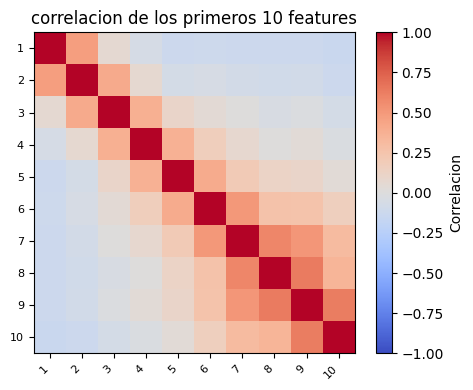

In [16]:
corr_prim = df_prim_features_f_1.iloc[:, 1:11].corr()
plt.figure(figsize=(5, 4))
im = plt.imshow(corr_prim, cmap='coolwarm', vmin=-1, vmax=1)
plt.colorbar(label='Correlacion')
plt.title("correlacion de los primeros 10 features")
plt.xticks(range(10), df_prim_features_f_1.columns[1:11], rotation=45, ha='right', fontsize=8)
plt.yticks(range(10), df_prim_features_f_1.columns[1:11], fontsize=8)
plt.tight_layout()
plt.show()

Como vemos hay algunos features que tienen una correlacuon un poco alta. Teniendo esto en cuenta, eliminaremos los features que tienen correlacion mayor a 0.9 o menor a -0.9.

In [17]:
corr_matrix = df_prim_features_f_1.corr().abs()

upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))

umbral = 0.9
columnas_a_eliminar = [col for col in upper.columns if any(upper[col] > umbral)]

df_prim_features_f_2 = df_prim_features_f_1.drop(columns=columnas_a_eliminar)

display(df_prim_features_f_2)

,0,1,2,3,4,5,6,7,8,9,...,87,88,89,90,91,92,93,94,95,96
0,2012.0,804.0,551.0,428.0,617.0,597.0,312.0,22.0,76.0,2.0,...,140.0,191.0,226.0,306.0,189.0,130.0,91.0,123.0,1455.0,0.536360
1,10785.0,5957.0,3525.0,1440.0,432.0,704.0,566.0,1753.0,2599.0,1370.0,...,855.0,755.0,697.0,614.0,638.0,723.0,977.0,1579.0,8005.0,0.192786
2,447.0,46.0,0.0,4.0,0.0,4.0,0.0,0.0,7.0,0.0,...,760.0,653.0,572.0,454.0,236.0,144.0,102.0,161.0,956.0,0.117558
3,16814.0,10853.0,12849.0,5761.0,2291.0,257.0,72.0,18.0,41.0,1.0,...,632.0,677.0,759.0,873.0,968.0,1126.0,1415.0,2170.0,6420.0,0.265118
4,13524.0,901.0,2781.0,5000.0,897.0,1031.0,1017.0,772.0,1376.0,1403.0,...,655.0,660.0,748.0,994.0,1659.0,5446.0,10767.0,18614.0,2610.0,0.314388
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5461,28658.0,1829.0,902.0,1494.0,111.0,441.0,88.0,55.0,154.0,35.0,...,287.0,212.0,149.0,97.0,110.0,89.0,74.0,68.0,452.0,0.431729
5462,1326.0,1905.0,11639.0,18130.0,2089.0,710.0,497.0,275.0,298.0,315.0,...,1255.0,1376.0,1545.0,2131.0,2977.0,4620.0,7323.0,6374.0,4690.0,0.103473
5463,28057.0,5984.0,3909.0,3184.0,730.0,724.0,258.0,81.0,160.0,32.0,...,619.0,613.0,679.0,705.0,746.0,739.0,721.0,374.0,348.0,0.172851
5464,7960.0,1969.0,4332.0,4243.0,2806.0,2890.0,2779.0,5445.0,5969.0,2164.0,...,416.0,434.0,389.0,363.0,423.0,404.0,536.0,567.0,1402.0,0.177936


Al final no se encontro features con correlacion mayor a 0.9 o menor a -0.9.

Ahora, como no hemos eliminado ni hemos alterado el orden de los samples, podemos volver a colocar la columna movieId para luego hacer un merge con las demas.

In [18]:
df_prim_features_f_2["movieId"] = df_prim_features["movieId"]

cols = ['movieId'] + [col for col in df_prim_features_f_2.columns if col != 'movieId']
df_prim_filt = df_prim_features_f_2[cols]

display(df_prim_filt)

,movieId,0,1,2,3,4,5,6,7,8,...,87,88,89,90,91,92,93,94,95,96
0,163527,2012.0,804.0,551.0,428.0,617.0,597.0,312.0,22.0,76.0,...,140.0,191.0,226.0,306.0,189.0,130.0,91.0,123.0,1455.0,0.536360
1,180987,10785.0,5957.0,3525.0,1440.0,432.0,704.0,566.0,1753.0,2599.0,...,855.0,755.0,697.0,614.0,638.0,723.0,977.0,1579.0,8005.0,0.192786
2,168712,447.0,46.0,0.0,4.0,0.0,4.0,0.0,0.0,7.0,...,760.0,653.0,572.0,454.0,236.0,144.0,102.0,161.0,956.0,0.117558
3,185435,16814.0,10853.0,12849.0,5761.0,2291.0,257.0,72.0,18.0,41.0,...,632.0,677.0,759.0,873.0,968.0,1126.0,1415.0,2170.0,6420.0,0.265118
4,171751,13524.0,901.0,2781.0,5000.0,897.0,1031.0,1017.0,772.0,1376.0,...,655.0,660.0,748.0,994.0,1659.0,5446.0,10767.0,18614.0,2610.0,0.314388
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5461,32600,28658.0,1829.0,902.0,1494.0,111.0,441.0,88.0,55.0,154.0,...,287.0,212.0,149.0,97.0,110.0,89.0,74.0,68.0,452.0,0.431729
5462,65135,1326.0,1905.0,11639.0,18130.0,2089.0,710.0,497.0,275.0,298.0,...,1255.0,1376.0,1545.0,2131.0,2977.0,4620.0,7323.0,6374.0,4690.0,0.103473
5463,102278,28057.0,5984.0,3909.0,3184.0,730.0,724.0,258.0,81.0,160.0,...,619.0,613.0,679.0,705.0,746.0,739.0,721.0,374.0,348.0,0.172851
5464,74075,7960.0,1969.0,4332.0,4243.0,2806.0,2890.0,2779.0,5445.0,5969.0,...,416.0,434.0,389.0,363.0,423.0,404.0,536.0,567.0,1402.0,0.177936


### sec_features.csv

El proceso que hicimos en prim_features.csv lo repetiremos aqui.

In [19]:
sec_features_path = "../data/features_main_dataset/sec_features.csv"
df_sec_features = pd.read_csv(sec_features_path)
display(df_sec_features)

,movieId,0,1,2,3,4,5,6,7,8,...,103,104,105,106,107,108,109,110,111,112
0,163527,2012.0,804.0,551.0,428.0,617.0,597.0,312.0,22.0,76.0,...,0.047521,0.536360,0.069162,0.004495,2.304067e-06,2.329233e-08,2.095254e-08,4.625556e-16,3.169477e-11,1.713062e-17
1,168712,1367.0,15.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,...,0.063970,0.172059,0.073323,0.002557,6.273314e-07,2.181894e-09,1.778461e-09,2.986593e-18,1.407163e-12,1.831311e-18
2,185435,17025.0,10815.0,12600.0,5783.0,2336.0,265.0,67.0,26.0,60.0,...,0.061657,0.247385,0.099553,0.001457,3.458434e-08,1.031054e-10,1.471996e-11,5.562673e-22,2.717854e-15,-1.393515e-22
3,171751,17506.0,3290.0,3687.0,1959.0,736.0,1856.0,259.0,90.0,438.0,...,0.073829,0.327338,0.110694,0.000946,1.191259e-07,1.174236e-12,4.371767e-12,3.552694e-24,1.419026e-15,9.246149e-24
4,167746,1161.0,692.0,1264.0,5030.0,28157.0,5922.0,534.0,279.0,310.0,...,0.084017,0.109353,0.122497,0.001183,1.861173e-07,7.335592e-12,1.932205e-11,1.533885e-22,8.148779e-15,-1.714319e-22
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6744,68600,3835.0,6771.0,5590.0,2333.0,1400.0,7914.0,1136.0,1262.0,1198.0,...,0.084309,0.149776,0.131149,0.001098,2.210971e-07,1.840865e-12,4.677070e-12,-1.357682e-23,2.190030e-15,2.002574e-24
6745,27762,8634.0,9707.0,7868.0,4210.0,8280.0,268.0,178.0,103.0,74.0,...,0.086564,0.210733,0.156601,0.001410,3.018746e-07,4.137962e-11,5.289703e-11,2.473332e-21,2.903338e-14,-8.524194e-23
6746,65135,1199.0,729.0,20044.0,22626.0,4148.0,1660.0,290.0,3.0,14.0,...,0.084134,0.251332,0.125608,0.001444,2.811447e-07,1.887388e-10,1.563565e-11,6.438917e-22,-2.583350e-15,5.539476e-22
6747,102278,20089.0,917.0,691.0,727.0,514.0,1667.0,534.0,382.0,942.0,...,0.076959,0.303558,0.115302,0.001195,1.649676e-07,1.236173e-12,1.086804e-12,1.038412e-24,4.357872e-16,-7.131203e-25


In [20]:
df_sec_features.describe()

,movieId,0,1,2,3,4,5,6,7,8,...,103,104,105,106,107,108,109,110,111,112
count,6749.000000,6749.000000,6749.000000,6749.000000,6749.000000,6749.000000,6749.000000,6749.000000,6749.000000,6749.000000,...,6749.000000,6749.000000,6749.000000,6749.000000,6.749000e+03,6.749000e+03,6.749000e+03,6.749000e+03,6.749000e+03,6.749000e+03
mean,41806.732701,9429.694325,4659.577567,5141.273522,3953.487183,2450.586754,1793.693436,901.027115,498.120314,521.769151,...,0.077163,0.204513,0.118783,0.001768,6.955917e-07,8.592991e-10,6.965806e-10,2.119952e-17,1.456342e-12,-1.101226e-18
std,51815.856627,9379.540620,4537.202871,5242.416733,4796.483038,3975.295366,2797.691083,1840.474512,1313.688340,1229.489915,...,0.016170,0.126307,0.028691,0.000953,2.337677e-06,4.845128e-09,5.247825e-09,4.759809e-16,2.001990e-11,1.266317e-16
min,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.007389,0.052532,0.022944,0.000721,1.265654e-10,1.791802e-16,1.130432e-16,-2.031377e-16,-3.265271e-11,-5.190351e-15
25%,3240.000000,2476.000000,1414.000000,1349.000000,844.000000,336.000000,361.000000,108.000000,46.000000,85.000000,...,0.068509,0.113183,0.099553,0.001181,1.457708e-07,9.016027e-12,7.241987e-12,3.820454e-25,5.854082e-16,-5.151252e-22
50%,7251.000000,6193.000000,3440.000000,3707.000000,2373.000000,1061.000000,941.000000,341.000000,148.000000,221.000000,...,0.079992,0.157321,0.119861,0.001489,2.602622e-07,5.453097e-11,3.882264e-11,3.586535e-22,9.055087e-15,-3.057314e-29
75%,75389.000000,13491.000000,6483.000000,7196.000000,5206.000000,2825.000000,2078.000000,908.000000,427.000000,491.000000,...,0.088509,0.257969,0.139199,0.002012,5.490281e-07,2.767722e-10,1.878672e-10,1.642995e-20,7.619517e-14,5.217659e-22
max,193609.000000,51430.000000,40748.000000,43207.000000,44662.000000,43492.000000,42866.000000,31209.000000,30946.000000,34561.000000,...,0.145810,0.872487,0.231771,0.015431,1.137184e-04,1.105738e-07,1.912956e-07,2.278345e-14,7.838120e-10,4.186372e-15


In [21]:
df_sec_features.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6749 entries, 0 to 6748
Columns: 114 entries, movieId to 112
dtypes: float64(113), int64(1)
memory usage: 5.9 MB


In [22]:
df_sec_features.isna().sum().sum()

np.int64(0)

Verificamos si hay duplicado en movieId

In [23]:
print(df_sec_features["movieId"].duplicated().any())

False


Al igual que hicimos en el prim_features, aqui tambien tenemos que eliminar el movieId

In [24]:
df_sec_features_f = df_sec_features.drop('movieId', axis=1)
df_sec_features_f

,0,1,2,3,4,5,6,7,8,9,...,103,104,105,106,107,108,109,110,111,112
0,2012.0,804.0,551.0,428.0,617.0,597.0,312.0,22.0,76.0,2.0,...,0.047521,0.536360,0.069162,0.004495,2.304067e-06,2.329233e-08,2.095254e-08,4.625556e-16,3.169477e-11,1.713062e-17
1,1367.0,15.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.063970,0.172059,0.073323,0.002557,6.273314e-07,2.181894e-09,1.778461e-09,2.986593e-18,1.407163e-12,1.831311e-18
2,17025.0,10815.0,12600.0,5783.0,2336.0,265.0,67.0,26.0,60.0,9.0,...,0.061657,0.247385,0.099553,0.001457,3.458434e-08,1.031054e-10,1.471996e-11,5.562673e-22,2.717854e-15,-1.393515e-22
3,17506.0,3290.0,3687.0,1959.0,736.0,1856.0,259.0,90.0,438.0,82.0,...,0.073829,0.327338,0.110694,0.000946,1.191259e-07,1.174236e-12,4.371767e-12,3.552694e-24,1.419026e-15,9.246149e-24
4,1161.0,692.0,1264.0,5030.0,28157.0,5922.0,534.0,279.0,310.0,146.0,...,0.084017,0.109353,0.122497,0.001183,1.861173e-07,7.335592e-12,1.932205e-11,1.533885e-22,8.148779e-15,-1.714319e-22
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6744,3835.0,6771.0,5590.0,2333.0,1400.0,7914.0,1136.0,1262.0,1198.0,621.0,...,0.084309,0.149776,0.131149,0.001098,2.210971e-07,1.840865e-12,4.677070e-12,-1.357682e-23,2.190030e-15,2.002574e-24
6745,8634.0,9707.0,7868.0,4210.0,8280.0,268.0,178.0,103.0,74.0,60.0,...,0.086564,0.210733,0.156601,0.001410,3.018746e-07,4.137962e-11,5.289703e-11,2.473332e-21,2.903338e-14,-8.524194e-23
6746,1199.0,729.0,20044.0,22626.0,4148.0,1660.0,290.0,3.0,14.0,0.0,...,0.084134,0.251332,0.125608,0.001444,2.811447e-07,1.887388e-10,1.563565e-11,6.438917e-22,-2.583350e-15,5.539476e-22
6747,20089.0,917.0,691.0,727.0,514.0,1667.0,534.0,382.0,942.0,209.0,...,0.076959,0.303558,0.115302,0.001195,1.649676e-07,1.236173e-12,1.086804e-12,1.038412e-24,4.357872e-16,-7.131203e-25


Ahora verificamos y eliminamos features con varianza muy baja, al igual que en el anterior dataset.

In [25]:
display(df_sec_features_f.var().sort_values())

112    1.603558e-32
110    2.265578e-31
111    4.007962e-22
108    2.347526e-17
109    2.753967e-17
           ...     
2      2.748293e+07
64     5.083773e+07
95     7.738781e+07
0      8.797578e+07
32     1.085265e+08
Length: 113, dtype: float64

In [26]:
selector = VarianceThreshold(threshold=0.01) # El umbral elegido sera 0.01
df_sec_features_f_1 = selector.fit_transform(df_sec_features_f)
df_sec_features_f_1 = pd.DataFrame(df_sec_features_f_1)
display(df_sec_features_f_1)

,0,1,2,3,4,5,6,7,8,9,...,87,88,89,90,91,92,93,94,95,96
0,2012.0,804.0,551.0,428.0,617.0,597.0,312.0,22.0,76.0,2.0,...,140.0,191.0,226.0,306.0,189.0,130.0,91.0,123.0,1455.0,0.536360
1,1367.0,15.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,...,545.0,453.0,402.0,291.0,207.0,102.0,66.0,28.0,64.0,0.172059
2,17025.0,10815.0,12600.0,5783.0,2336.0,265.0,67.0,26.0,60.0,9.0,...,718.0,718.0,795.0,912.0,965.0,1153.0,1370.0,2130.0,6612.0,0.247385
3,17506.0,3290.0,3687.0,1959.0,736.0,1856.0,259.0,90.0,438.0,82.0,...,631.0,647.0,739.0,832.0,927.0,1125.0,1739.0,2885.0,30016.0,0.327338
4,1161.0,692.0,1264.0,5030.0,28157.0,5922.0,534.0,279.0,310.0,146.0,...,887.0,1032.0,1289.0,2221.0,2400.0,3069.0,4003.0,5174.0,13642.0,0.109353
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6744,3835.0,6771.0,5590.0,2333.0,1400.0,7914.0,1136.0,1262.0,1198.0,621.0,...,1854.0,2141.0,2665.0,3403.0,3094.0,7433.0,4510.0,4555.0,8149.0,0.149776
6745,8634.0,9707.0,7868.0,4210.0,8280.0,268.0,178.0,103.0,74.0,60.0,...,1252.0,1564.0,2104.0,2311.0,2376.0,2203.0,6618.0,2809.0,10265.0,0.210733
6746,1199.0,729.0,20044.0,22626.0,4148.0,1660.0,290.0,3.0,14.0,0.0,...,1034.0,1024.0,1153.0,1291.0,1430.0,1884.0,2761.0,609.0,1449.0,0.251332
6747,20089.0,917.0,691.0,727.0,514.0,1667.0,534.0,382.0,942.0,209.0,...,673.0,651.0,746.0,675.0,689.0,745.0,818.0,1305.0,12269.0,0.303558


Ahora verificamos las primeras correlaciones, y eliminamos los features que tienen una correlacion mayor a 0.9 y menor a -0.9

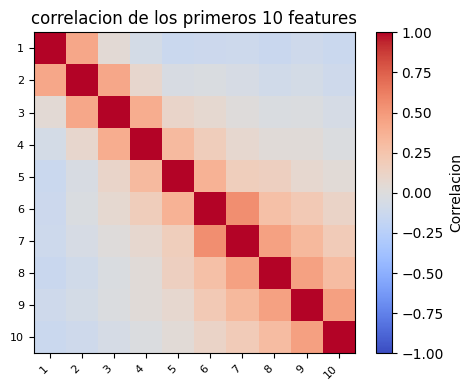

In [27]:
corr_prim = df_sec_features_f_1.iloc[:, 1:11].corr()
plt.figure(figsize=(5, 4))
im = plt.imshow(corr_prim, cmap='coolwarm', vmin=-1, vmax=1)
plt.colorbar(label='Correlacion')
plt.title("correlacion de los primeros 10 features")
plt.xticks(range(10), df_sec_features_f_1.columns[1:11], rotation=45, ha='right', fontsize=8)
plt.yticks(range(10), df_sec_features_f_1.columns[1:11], fontsize=8)
plt.tight_layout()
plt.show()

Vemos que al menos para las primeras 10 features, tenemos una similutud con los posters en prim_features.

In [28]:
corr_matrix = df_sec_features_f_1.corr().abs()

upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))

umbral = 0.9
columnas_a_eliminar = [col for col in upper.columns if any(upper[col] > umbral)]

df_sec_features_f_2 = df_sec_features_f_1.drop(columns=columnas_a_eliminar)

display(df_sec_features_f_2)

,0,1,2,3,4,5,6,7,8,9,...,87,88,89,90,91,92,93,94,95,96
0,2012.0,804.0,551.0,428.0,617.0,597.0,312.0,22.0,76.0,2.0,...,140.0,191.0,226.0,306.0,189.0,130.0,91.0,123.0,1455.0,0.536360
1,1367.0,15.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,...,545.0,453.0,402.0,291.0,207.0,102.0,66.0,28.0,64.0,0.172059
2,17025.0,10815.0,12600.0,5783.0,2336.0,265.0,67.0,26.0,60.0,9.0,...,718.0,718.0,795.0,912.0,965.0,1153.0,1370.0,2130.0,6612.0,0.247385
3,17506.0,3290.0,3687.0,1959.0,736.0,1856.0,259.0,90.0,438.0,82.0,...,631.0,647.0,739.0,832.0,927.0,1125.0,1739.0,2885.0,30016.0,0.327338
4,1161.0,692.0,1264.0,5030.0,28157.0,5922.0,534.0,279.0,310.0,146.0,...,887.0,1032.0,1289.0,2221.0,2400.0,3069.0,4003.0,5174.0,13642.0,0.109353
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6744,3835.0,6771.0,5590.0,2333.0,1400.0,7914.0,1136.0,1262.0,1198.0,621.0,...,1854.0,2141.0,2665.0,3403.0,3094.0,7433.0,4510.0,4555.0,8149.0,0.149776
6745,8634.0,9707.0,7868.0,4210.0,8280.0,268.0,178.0,103.0,74.0,60.0,...,1252.0,1564.0,2104.0,2311.0,2376.0,2203.0,6618.0,2809.0,10265.0,0.210733
6746,1199.0,729.0,20044.0,22626.0,4148.0,1660.0,290.0,3.0,14.0,0.0,...,1034.0,1024.0,1153.0,1291.0,1430.0,1884.0,2761.0,609.0,1449.0,0.251332
6747,20089.0,917.0,691.0,727.0,514.0,1667.0,534.0,382.0,942.0,209.0,...,673.0,651.0,746.0,675.0,689.0,745.0,818.0,1305.0,12269.0,0.303558


Al igual que en prim_features, aqui no encontramos correlaciones tan altas o tan bajas para eliminarlas.

Ahora, solo nos queda agregar nuevamente la columna de movieId

In [29]:
df_sec_features_f_2["movieId"] = df_sec_features["movieId"]

cols = ['movieId'] + [col for col in df_sec_features_f_2.columns if col != 'movieId']
df_sec_filt = df_sec_features_f_2[cols]

display(df_sec_filt)

,movieId,0,1,2,3,4,5,6,7,8,...,87,88,89,90,91,92,93,94,95,96
0,163527,2012.0,804.0,551.0,428.0,617.0,597.0,312.0,22.0,76.0,...,140.0,191.0,226.0,306.0,189.0,130.0,91.0,123.0,1455.0,0.536360
1,168712,1367.0,15.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,...,545.0,453.0,402.0,291.0,207.0,102.0,66.0,28.0,64.0,0.172059
2,185435,17025.0,10815.0,12600.0,5783.0,2336.0,265.0,67.0,26.0,60.0,...,718.0,718.0,795.0,912.0,965.0,1153.0,1370.0,2130.0,6612.0,0.247385
3,171751,17506.0,3290.0,3687.0,1959.0,736.0,1856.0,259.0,90.0,438.0,...,631.0,647.0,739.0,832.0,927.0,1125.0,1739.0,2885.0,30016.0,0.327338
4,167746,1161.0,692.0,1264.0,5030.0,28157.0,5922.0,534.0,279.0,310.0,...,887.0,1032.0,1289.0,2221.0,2400.0,3069.0,4003.0,5174.0,13642.0,0.109353
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6744,68600,3835.0,6771.0,5590.0,2333.0,1400.0,7914.0,1136.0,1262.0,1198.0,...,1854.0,2141.0,2665.0,3403.0,3094.0,7433.0,4510.0,4555.0,8149.0,0.149776
6745,27762,8634.0,9707.0,7868.0,4210.0,8280.0,268.0,178.0,103.0,74.0,...,1252.0,1564.0,2104.0,2311.0,2376.0,2203.0,6618.0,2809.0,10265.0,0.210733
6746,65135,1199.0,729.0,20044.0,22626.0,4148.0,1660.0,290.0,3.0,14.0,...,1034.0,1024.0,1153.0,1291.0,1430.0,1884.0,2761.0,609.0,1449.0,0.251332
6747,102278,20089.0,917.0,691.0,727.0,514.0,1667.0,534.0,382.0,942.0,...,673.0,651.0,746.0,675.0,689.0,745.0,818.0,1305.0,12269.0,0.303558


# Reduccion de la Dimensionalidad

Para la reduccion de la dimencionalidad, lo que haremos sera usar 2 algoritmos para hacer la reduccion de forma concatenada y uno para la visualizacion:

* PCA -> UMAP : Usamos estos dos algoritmos en ese orden ya que primero el PCA eliminara el ruido y el UMAP preservara la estructura local y bajara la cantidad de features a 10.

* PCA : Usamos PCA para visualizar los clusters proque permite reducir los vectores de caracteristicas extraidos a solo dimensiones, conservando la mayor parte de la varianza de los datos. Esto nos es util para representar visualemente la estructura general sin perder informacion relevante. 

In [ ]:
%pip install umap-learn

In [ ]:

import pandas as pd
import numpy as np
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import umap.umap_ as umap

/Users/acerog/Documents/UTEC/Machine Learning/Projects/2/venv/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [43]:
def pca_umap_reduction(features, n_components_pca=50, n_components_umap=10, random_state=42):
    pca = PCA(n_components=n_components_pca, svd_solver='randomized', random_state=random_state)

    features_pca = pca.fit_transform(features)

    umap_reducer = umap.UMAP(
        n_components=n_components_umap,
        random_state=random_state,
        n_neighbors=15,
        min_dist=0.1,
        metric='euclidean'
    )
    
    features_final = umap_reducer.fit_transform(features_pca)

    return features_final

Para esta parte, lo que haremos sera construir diversos datasets con los que ya tenemos, de tal forma que podamos probarlos todos.

Solo prim_filt

Primero tenemos que escalar el dataset df_prim_filt.

In [70]:
df_prim_filt_scal = df_prim_filt.drop('movieId', axis=1)
df_prim_filt_scal

,0,1,2,3,4,5,6,7,8,9,...,87,88,89,90,91,92,93,94,95,96
0,2012.0,804.0,551.0,428.0,617.0,597.0,312.0,22.0,76.0,2.0,...,140.0,191.0,226.0,306.0,189.0,130.0,91.0,123.0,1455.0,0.536360
1,10785.0,5957.0,3525.0,1440.0,432.0,704.0,566.0,1753.0,2599.0,1370.0,...,855.0,755.0,697.0,614.0,638.0,723.0,977.0,1579.0,8005.0,0.192786
2,447.0,46.0,0.0,4.0,0.0,4.0,0.0,0.0,7.0,0.0,...,760.0,653.0,572.0,454.0,236.0,144.0,102.0,161.0,956.0,0.117558
3,16814.0,10853.0,12849.0,5761.0,2291.0,257.0,72.0,18.0,41.0,1.0,...,632.0,677.0,759.0,873.0,968.0,1126.0,1415.0,2170.0,6420.0,0.265118
4,13524.0,901.0,2781.0,5000.0,897.0,1031.0,1017.0,772.0,1376.0,1403.0,...,655.0,660.0,748.0,994.0,1659.0,5446.0,10767.0,18614.0,2610.0,0.314388
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5461,28658.0,1829.0,902.0,1494.0,111.0,441.0,88.0,55.0,154.0,35.0,...,287.0,212.0,149.0,97.0,110.0,89.0,74.0,68.0,452.0,0.431729
5462,1326.0,1905.0,11639.0,18130.0,2089.0,710.0,497.0,275.0,298.0,315.0,...,1255.0,1376.0,1545.0,2131.0,2977.0,4620.0,7323.0,6374.0,4690.0,0.103473
5463,28057.0,5984.0,3909.0,3184.0,730.0,724.0,258.0,81.0,160.0,32.0,...,619.0,613.0,679.0,705.0,746.0,739.0,721.0,374.0,348.0,0.172851
5464,7960.0,1969.0,4332.0,4243.0,2806.0,2890.0,2779.0,5445.0,5969.0,2164.0,...,416.0,434.0,389.0,363.0,423.0,404.0,536.0,567.0,1402.0,0.177936


In [71]:
scaler = StandardScaler()
df_prim_filt_scal = scaler.fit_transform(df_prim_filt_scal)
df_prim_filt_scal

array([[-0.77792822, -0.78773317, -0.82851746, ..., -0.76795879,
        -0.6968006 ,  2.75423401],
       [ 0.16475244,  0.43310035, -0.22932772, ..., -0.2278827 ,
         0.05576563, -0.1590128 ],
       [-0.94609136, -0.96731629, -0.93953076, ..., -0.7538634 ,
        -0.75413351, -0.79689349],
       ...,
       [ 2.02067178,  0.43949711, -0.15196092, ..., -0.67485501,
        -0.82399004, -0.3280458 ],
       [-0.13880083, -0.51172482, -0.06673656, ..., -0.60326526,
        -0.70289007, -0.28493335],
       [-0.2388391 ,  0.42978351,  0.01969666, ...,  0.46650084,
         0.61186038, -0.57333481]], shape=(5466, 97))

In [72]:
df_prim_filt_scal = pd.DataFrame(df_prim_filt_scal)
df_prim_filt_scal

,0,1,2,3,4,5,6,7,8,9,...,87,88,89,90,91,92,93,94,95,96
0,-0.777928,-0.787733,-0.828517,-0.716700,-0.472472,-0.462475,-0.320981,-0.391456,-0.335393,-0.367643,...,-0.986618,-1.034257,-0.961265,-0.813257,-0.892391,-0.809758,-0.785472,-0.767959,-0.696801,2.754234
1,0.164752,0.433100,-0.229328,-0.495107,-0.518986,-0.427474,-0.195710,1.195162,1.770415,1.488516,...,-0.305070,-0.463191,-0.536123,-0.583139,-0.590524,-0.503731,-0.403529,-0.227883,0.055766,-0.159013
2,-0.946091,-0.967316,-0.939531,-0.809542,-0.627602,-0.656454,-0.474859,-0.411621,-0.392983,-0.370356,...,-0.395626,-0.566469,-0.648953,-0.702681,-0.860792,-0.802533,-0.780730,-0.753863,-0.754134,-0.796893
3,0.812583,1.593046,1.649235,0.451045,-0.051585,-0.573694,-0.439348,-0.395122,-0.364606,-0.368999,...,-0.517637,-0.542168,-0.480160,-0.389631,-0.368662,-0.295756,-0.214713,-0.008662,-0.126344,0.454302
4,0.459065,-0.764752,-0.379226,0.284412,-0.402073,-0.320508,0.026722,0.295987,0.749645,1.533292,...,-0.495713,-0.559381,-0.490089,-0.299227,0.095904,1.933647,3.816809,6.090933,-0.564096,0.872082
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5461,2.085251,-0.544893,-0.757799,-0.483282,-0.599694,-0.513505,-0.431457,-0.361208,-0.270291,-0.322867,...,-0.846496,-1.012994,-1.030769,-0.969409,-0.945503,-0.830916,-0.792800,-0.788360,-0.812041,1.867039
5462,-0.851641,-0.526888,1.405449,3.159433,-0.102373,-0.425511,-0.229740,-0.159559,-0.150102,0.057049,...,0.076215,0.165591,0.229314,0.550267,0.982007,1.507377,2.332147,1.550733,-0.325113,-0.916322
5463,2.020672,0.439497,-0.151961,-0.113230,-0.444061,-0.420932,-0.347614,-0.337377,-0.265283,-0.326937,...,-0.530029,-0.606970,-0.552371,-0.515150,-0.517914,-0.495474,-0.513887,-0.674855,-0.823990,-0.328046
5464,-0.138801,-0.511725,-0.066737,0.118655,0.077900,0.287597,0.895733,4.579214,4.583167,2.565848,...,-0.723531,-0.788213,-0.814136,-0.770670,-0.735070,-0.668356,-0.593638,-0.603265,-0.702890,-0.284933


In [73]:
df_prim_filt_reduced = pca_umap_reduction(df_prim_filt_scal)
df_prim_filt_reduced

/Users/acerog/Documents/UTEC/Machine Learning/Projects/2/venv/lib/python3.13/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/acerog/Documents/UTEC/Machine Learning/Projects/2/venv/lib/python3.13/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


array([[1.7505188, 6.453828 , 4.37085  , ..., 7.6129646, 6.158206 ,
        5.016167 ],
       [0.7763307, 7.2054167, 3.6981647, ..., 7.947708 , 6.4679627,
        5.139723 ],
       [0.90411  , 6.7485666, 3.9603844, ..., 7.0330195, 6.055568 ,
        4.937671 ],
       ...,
       [2.6529024, 6.690335 , 5.2667537, ..., 7.8527822, 6.704041 ,
        5.0093164],
       [1.8318733, 8.113756 , 3.7943835, ..., 6.207707 , 6.50028  ,
        4.8912563],
       [0.7477875, 7.6914024, 4.8103943, ..., 7.6610856, 7.1560373,
        5.076274 ]], shape=(5466, 10), dtype=float32)

In [74]:
df_prim_filt_reduced = pd.DataFrame(df_prim_filt_reduced)
df_prim_filt_reduced

,0,1,2,3,4,5,6,7,8,9
0,1.750519,6.453828,4.370850,6.372600,3.719936,7.402461,3.464062,7.612965,6.158206,5.016167
1,0.776331,7.205417,3.698165,6.537938,3.411596,6.627668,3.559534,7.947708,6.467963,5.139723
2,0.904110,6.748567,3.960384,6.140927,3.619421,6.862321,3.610333,7.033020,6.055568,4.937671
3,1.105154,6.450739,4.794130,8.045794,5.436633,5.471364,4.006347,8.879725,6.928748,4.538281
4,2.435279,7.928036,6.358868,7.849895,2.676047,6.108432,3.567994,7.792952,7.728940,5.348948
...,...,...,...,...,...,...,...,...,...,...
5461,2.117908,6.049182,5.064870,7.939770,5.518686,6.278388,3.814454,8.707533,6.680794,4.552061
5462,0.406041,7.625036,4.295228,7.828126,4.103240,5.108999,3.937724,8.661416,7.280746,4.959147
5463,2.652902,6.690335,5.266754,7.349321,4.011132,7.001399,3.508417,7.852782,6.704041,5.009316
5464,1.831873,8.113756,3.794384,7.345428,3.785516,5.861362,3.590199,6.207707,6.500280,4.891256


Le Volvemos a agregar la columna de movieId

In [75]:
df_prim_filt_reduced["movieId"] = df_prim_filt["movieId"]

cols = ['movieId'] + [col for col in df_prim_filt_reduced.columns if col != 'movieId']
df_prim_reduced = df_prim_filt_reduced[cols]

display(df_prim_reduced)

,movieId,0,1,2,3,4,5,6,7,8,9
0,163527,1.750519,6.453828,4.370850,6.372600,3.719936,7.402461,3.464062,7.612965,6.158206,5.016167
1,180987,0.776331,7.205417,3.698165,6.537938,3.411596,6.627668,3.559534,7.947708,6.467963,5.139723
2,168712,0.904110,6.748567,3.960384,6.140927,3.619421,6.862321,3.610333,7.033020,6.055568,4.937671
3,185435,1.105154,6.450739,4.794130,8.045794,5.436633,5.471364,4.006347,8.879725,6.928748,4.538281
4,171751,2.435279,7.928036,6.358868,7.849895,2.676047,6.108432,3.567994,7.792952,7.728940,5.348948
...,...,...,...,...,...,...,...,...,...,...,...
5461,32600,2.117908,6.049182,5.064870,7.939770,5.518686,6.278388,3.814454,8.707533,6.680794,4.552061
5462,65135,0.406041,7.625036,4.295228,7.828126,4.103240,5.108999,3.937724,8.661416,7.280746,4.959147
5463,102278,2.652902,6.690335,5.266754,7.349321,4.011132,7.001399,3.508417,7.852782,6.704041,5.009316
5464,74075,1.831873,8.113756,3.794384,7.345428,3.785516,5.861362,3.590199,6.207707,6.500280,4.891256


In [76]:
df_prim_reduced.to_csv("prim_reduced.csv")

Ahora, agrupamos en un dataframe de df_prim_reduced con los generos, de forma que tengamos otro dataset con el que trabajar

In [80]:
# Primero sacamos los generos del main.csv
df_main = pd.read_csv('../data/features_main_dataset/main.csv')
df_main

,Unnamed: 0,movieId,title,genres,(no genres listed),Action,Adventure,Animation,Children,Comedy,...,Thriller,War,Western,year,title_cleaned,imdbId,tmdbId,poster_url,poster_source,poster_url_tmbd
0,53,171751,Munna bhai M.B.B.S. (2003),Comedy,0,0,0,0,0,1,...,0,0,0,2003.0,Munna bhai M.B.B.S.,374887.0,19625.0,https://image.tmdb.org/t/p/w185/nZNUTxGsSB4nLE...,tmdb_by_id,https://image.tmdb.org/t/p/w185/OjJ2eZFMr0InHx...
1,56,163527,Comedy Central Roast of David Hasselhoff (2010),Comedy,0,0,0,0,0,1,...,0,0,0,2010.0,Comedy Central Roast of David Hasselhoff,1694505.0,296193.0,https://image.tmdb.org/t/p/w185/sX66iM4rds1pkL...,tmdb_by_id,https://image.tmdb.org/t/p/w185/sX66iM4rds1pkL...
2,79,193565,Gintama: The Movie (2010),Action|Animation|Comedy|Sci-Fi,0,1,0,1,0,1,...,0,0,0,2010.0,Gintama: The Movie,1636780.0,71172.0,https://image.tmdb.org/t/p/w185/E3RT3f8oOuPS2p...,tmdb_by_id,https://image.tmdb.org/t/p/w185/tIIS5ejoTOiyXl...
3,158,180987,Ferdinand (2017),Animation|Children|Comedy,0,0,0,1,1,1,...,0,0,0,2017.0,Ferdinand,3411444.0,364689.0,https://image.tmdb.org/t/p/w185/rMm94JsRfcOPiP...,tmdb_by_id,https://image.tmdb.org/t/p/w185/hC5FyR149ZOnXU...
4,171,167746,The Lego Batman Movie (2017),Action|Animation|Comedy,0,1,0,1,0,1,...,0,0,0,2017.0,The Lego Batman Movie,4116284.0,324849.0,https://image.tmdb.org/t/p/w185/snGwr2gag4Fcgx...,tmdb_by_id,https://image.tmdb.org/t/p/w185/9F7OQVDMmvUJVw...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6766,6458,27762,Comic Book: The Movie (2004),Comedy,0,0,0,0,0,1,...,0,0,0,2004.0,Comic Book: The Movie,NaN,NaN,https://images-na.ssl-images-amazon.com/images...,Kaggle_by_title,https://image.tmdb.org/t/p/w185/v0uYgoh74LYr6Q...
6767,6510,32600,Eros (2004),Drama,0,0,0,0,0,0,...,0,0,0,2004.0,Eros,377059.0,NaN,https://images-na.ssl-images-amazon.com/images...,Kaggle_by_id,https://image.tmdb.org/t/p/w185/z4G2JtLDZtYveX...
6768,6599,102278,Pawn (2013),Crime|Thriller,0,0,0,0,0,0,...,1,0,0,2013.0,Pawn,NaN,NaN,https://images-na.ssl-images-amazon.com/images...,Kaggle_by_title,https://image.tmdb.org/t/p/w185/x1xjvT12cF6CAB...
6769,6704,65135,Blackadder's Christmas Carol (1988),Comedy,0,0,0,0,0,1,...,0,0,0,1988.0,Blackadder's Christmas Carol,NaN,NaN,https://images-na.ssl-images-amazon.com/images...,Kaggle_by_title,https://image.tmdb.org/t/p/w185/zJD1sTuPlw3DoD...


In [81]:
df_main.columns

Index(['Unnamed: 0', 'movieId', 'title', 'genres', '(no genres listed)',
       'Action', 'Adventure', 'Animation', 'Children', 'Comedy', 'Crime',
       'Documentary', 'Drama', 'Fantasy', 'Film-Noir', 'Horror', 'IMAX',
       'Musical', 'Mystery', 'Romance', 'Sci-Fi', 'Thriller', 'War', 'Western',
       'year', 'title_cleaned', 'imdbId', 'tmdbId', 'poster_url',
       'poster_source', 'poster_url_tmbd'],
      dtype='object')

In [83]:
# Generamos el dataframe de Generos
df_generes = df_main[['movieId', '(no genres listed)', 'Action', 'Adventure', 'Animation', 'Children', 'Comedy', 'Crime', 'Documentary', 'Drama', 'Fantasy', 'Film-Noir', 'Horror', 'IMAX', 'Musical', 'Mystery', 'Romance', 'Sci-Fi', 'Thriller', 'War', 'Western']]
df_generes

,movieId,(no genres listed),Action,Adventure,Animation,Children,Comedy,Crime,Documentary,Drama,...,Film-Noir,Horror,IMAX,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
0,171751,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,163527,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,193565,0,1,0,1,0,1,0,0,0,...,0,0,0,0,0,0,1,0,0,0
3,180987,0,0,0,1,1,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,167746,0,1,0,1,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6766,27762,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
6767,32600,0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
6768,102278,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,1,0,0
6769,65135,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0


Ahora agregamos la columna movieId a df_prim_filt_scal para hacer un merge con df_generes, porque necesitamos los features visuales ya estandarizados para hacer la reduccion de la dimensionalidad. No importa el orden en el que esten porque al final lo volveremos a eliminar para hacer la reduccion.

In [84]:
df_prim_filt_scal["movieId"] = df_prim_filt["movieId"]
df_prim_filt_scal

,0,1,2,3,4,5,6,7,8,9,...,88,89,90,91,92,93,94,95,96,movieId
0,-0.777928,-0.787733,-0.828517,-0.716700,-0.472472,-0.462475,-0.320981,-0.391456,-0.335393,-0.367643,...,-1.034257,-0.961265,-0.813257,-0.892391,-0.809758,-0.785472,-0.767959,-0.696801,2.754234,163527
1,0.164752,0.433100,-0.229328,-0.495107,-0.518986,-0.427474,-0.195710,1.195162,1.770415,1.488516,...,-0.463191,-0.536123,-0.583139,-0.590524,-0.503731,-0.403529,-0.227883,0.055766,-0.159013,180987
2,-0.946091,-0.967316,-0.939531,-0.809542,-0.627602,-0.656454,-0.474859,-0.411621,-0.392983,-0.370356,...,-0.566469,-0.648953,-0.702681,-0.860792,-0.802533,-0.780730,-0.753863,-0.754134,-0.796893,168712
3,0.812583,1.593046,1.649235,0.451045,-0.051585,-0.573694,-0.439348,-0.395122,-0.364606,-0.368999,...,-0.542168,-0.480160,-0.389631,-0.368662,-0.295756,-0.214713,-0.008662,-0.126344,0.454302,185435
4,0.459065,-0.764752,-0.379226,0.284412,-0.402073,-0.320508,0.026722,0.295987,0.749645,1.533292,...,-0.559381,-0.490089,-0.299227,0.095904,1.933647,3.816809,6.090933,-0.564096,0.872082,171751
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5461,2.085251,-0.544893,-0.757799,-0.483282,-0.599694,-0.513505,-0.431457,-0.361208,-0.270291,-0.322867,...,-1.012994,-1.030769,-0.969409,-0.945503,-0.830916,-0.792800,-0.788360,-0.812041,1.867039,32600
5462,-0.851641,-0.526888,1.405449,3.159433,-0.102373,-0.425511,-0.229740,-0.159559,-0.150102,0.057049,...,0.165591,0.229314,0.550267,0.982007,1.507377,2.332147,1.550733,-0.325113,-0.916322,65135
5463,2.020672,0.439497,-0.151961,-0.113230,-0.444061,-0.420932,-0.347614,-0.337377,-0.265283,-0.326937,...,-0.606970,-0.552371,-0.515150,-0.517914,-0.495474,-0.513887,-0.674855,-0.823990,-0.328046,102278
5464,-0.138801,-0.511725,-0.066737,0.118655,0.077900,0.287597,0.895733,4.579214,4.583167,2.565848,...,-0.788213,-0.814136,-0.770670,-0.735070,-0.668356,-0.593638,-0.603265,-0.702890,-0.284933,74075


In [86]:
df_prim_genere_scal = pd.merge(df_prim_filt_scal, df_generes, on='movieId', how='inner')
df_prim_genere_scal

,0,1,2,3,4,5,6,7,8,9,...,Film-Noir,Horror,IMAX,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
0,-0.777928,-0.787733,-0.828517,-0.716700,-0.472472,-0.462475,-0.320981,-0.391456,-0.335393,-0.367643,...,0,0,0,0,0,0,0,0,0,0
1,0.164752,0.433100,-0.229328,-0.495107,-0.518986,-0.427474,-0.195710,1.195162,1.770415,1.488516,...,0,0,0,0,0,0,0,0,0,0
2,-0.946091,-0.967316,-0.939531,-0.809542,-0.627602,-0.656454,-0.474859,-0.411621,-0.392983,-0.370356,...,0,0,0,0,0,1,0,0,0,0
3,0.812583,1.593046,1.649235,0.451045,-0.051585,-0.573694,-0.439348,-0.395122,-0.364606,-0.368999,...,0,0,0,0,0,0,0,0,0,0
4,0.459065,-0.764752,-0.379226,0.284412,-0.402073,-0.320508,0.026722,0.295987,0.749645,1.533292,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5461,2.085251,-0.544893,-0.757799,-0.483282,-0.599694,-0.513505,-0.431457,-0.361208,-0.270291,-0.322867,...,0,0,0,0,0,0,0,0,0,0
5462,-0.851641,-0.526888,1.405449,3.159433,-0.102373,-0.425511,-0.229740,-0.159559,-0.150102,0.057049,...,0,0,0,0,0,0,0,0,0,0
5463,2.020672,0.439497,-0.151961,-0.113230,-0.444061,-0.420932,-0.347614,-0.337377,-0.265283,-0.326937,...,0,0,0,0,0,0,0,1,0,0
5464,-0.138801,-0.511725,-0.066737,0.118655,0.077900,0.287597,0.895733,4.579214,4.583167,2.565848,...,0,1,0,0,0,0,0,0,0,0


Volvemos a eliminar la columna movieId y aplicamos reduccion de la dimensionalidad.

In [87]:
df_prim_genere_scal = df_prim_genere_scal.drop('movieId', axis=1)
df_prim_genere_scal

,0,1,2,3,4,5,6,7,8,9,...,Film-Noir,Horror,IMAX,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
0,-0.777928,-0.787733,-0.828517,-0.716700,-0.472472,-0.462475,-0.320981,-0.391456,-0.335393,-0.367643,...,0,0,0,0,0,0,0,0,0,0
1,0.164752,0.433100,-0.229328,-0.495107,-0.518986,-0.427474,-0.195710,1.195162,1.770415,1.488516,...,0,0,0,0,0,0,0,0,0,0
2,-0.946091,-0.967316,-0.939531,-0.809542,-0.627602,-0.656454,-0.474859,-0.411621,-0.392983,-0.370356,...,0,0,0,0,0,1,0,0,0,0
3,0.812583,1.593046,1.649235,0.451045,-0.051585,-0.573694,-0.439348,-0.395122,-0.364606,-0.368999,...,0,0,0,0,0,0,0,0,0,0
4,0.459065,-0.764752,-0.379226,0.284412,-0.402073,-0.320508,0.026722,0.295987,0.749645,1.533292,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5461,2.085251,-0.544893,-0.757799,-0.483282,-0.599694,-0.513505,-0.431457,-0.361208,-0.270291,-0.322867,...,0,0,0,0,0,0,0,0,0,0
5462,-0.851641,-0.526888,1.405449,3.159433,-0.102373,-0.425511,-0.229740,-0.159559,-0.150102,0.057049,...,0,0,0,0,0,0,0,0,0,0
5463,2.020672,0.439497,-0.151961,-0.113230,-0.444061,-0.420932,-0.347614,-0.337377,-0.265283,-0.326937,...,0,0,0,0,0,0,0,1,0,0
5464,-0.138801,-0.511725,-0.066737,0.118655,0.077900,0.287597,0.895733,4.579214,4.583167,2.565848,...,0,1,0,0,0,0,0,0,0,0


Antes de continuar, tenemos que pasar los nombres de todas las columnas a string, en este caso, para que no seproduzcan incompatibilidades mas adelante

In [94]:
df_prim_genere_scal.columns = df_prim_genere_scal.columns.astype(str)

In [95]:
df_prim_genere_reduced = pca_umap_reduction(df_prim_genere_scal)
df_prim_genere_reduced

/Users/acerog/Documents/UTEC/Machine Learning/Projects/2/venv/lib/python3.13/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/acerog/Documents/UTEC/Machine Learning/Projects/2/venv/lib/python3.13/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


array([[1.9654188 , 7.1150312 , 4.174621  , ..., 7.821576  , 6.054333  ,
        4.928416  ],
       [0.90139824, 7.689952  , 3.5336902 , ..., 7.891337  , 6.318726  ,
        4.863761  ],
       [0.9914014 , 7.138491  , 3.6747553 , ..., 7.2563796 , 5.95346   ,
        4.908696  ],
       ...,
       [2.72023   , 7.253183  , 5.321717  , ..., 7.766954  , 6.3374844 ,
        4.7076178 ],
       [1.6619923 , 8.158645  , 3.9118838 , ..., 5.8241014 , 6.3064694 ,
        4.8522615 ],
       [0.68567365, 7.895958  , 4.8721857 , ..., 7.229613  , 6.6609974 ,
        4.665002  ]], shape=(5466, 10), dtype=float32)

In [96]:
df_prim_genere_reduced = pd.DataFrame(df_prim_genere_reduced)
df_prim_genere_reduced

,0,1,2,3,4,5,6,7,8,9
0,1.965419,7.115031,4.174621,6.240439,3.477040,7.072338,3.613646,7.821576,6.054333,4.928416
1,0.901398,7.689952,3.533690,6.386091,3.074313,6.115786,3.871853,7.891337,6.318726,4.863761
2,0.991401,7.138491,3.674755,5.870822,3.281806,6.767225,3.686115,7.256380,5.953460,4.908696
3,1.081169,6.726002,4.572569,7.752041,5.172688,4.964378,4.482362,8.261154,6.179292,3.833864
4,2.235527,8.310894,6.690618,7.132937,2.854205,5.309608,3.491738,7.456088,7.211291,4.964332
...,...,...,...,...,...,...,...,...,...,...
5461,2.057934,6.514019,4.916323,7.685126,5.281960,5.742873,4.225900,8.285825,6.055717,3.988080
5462,0.402432,7.911939,4.326387,7.426358,3.719740,4.422004,4.300275,7.990835,6.720502,4.325012
5463,2.720230,7.253183,5.321717,7.082315,3.993731,6.416372,3.611981,7.766954,6.337484,4.707618
5464,1.661992,8.158645,3.911884,6.836207,3.364223,5.603671,3.349954,5.824101,6.306469,4.852262


In [97]:
df_prim_genere_reduced["movieId"] = df_prim_filt["movieId"]

cols = ['movieId'] + [col for col in df_prim_genere_reduced.columns if col != 'movieId']
df_prim_genere_reduced = df_prim_genere_reduced[cols]

display(df_prim_genere_reduced)

,movieId,0,1,2,3,4,5,6,7,8,9
0,163527,1.965419,7.115031,4.174621,6.240439,3.477040,7.072338,3.613646,7.821576,6.054333,4.928416
1,180987,0.901398,7.689952,3.533690,6.386091,3.074313,6.115786,3.871853,7.891337,6.318726,4.863761
2,168712,0.991401,7.138491,3.674755,5.870822,3.281806,6.767225,3.686115,7.256380,5.953460,4.908696
3,185435,1.081169,6.726002,4.572569,7.752041,5.172688,4.964378,4.482362,8.261154,6.179292,3.833864
4,171751,2.235527,8.310894,6.690618,7.132937,2.854205,5.309608,3.491738,7.456088,7.211291,4.964332
...,...,...,...,...,...,...,...,...,...,...,...
5461,32600,2.057934,6.514019,4.916323,7.685126,5.281960,5.742873,4.225900,8.285825,6.055717,3.988080
5462,65135,0.402432,7.911939,4.326387,7.426358,3.719740,4.422004,4.300275,7.990835,6.720502,4.325012
5463,102278,2.720230,7.253183,5.321717,7.082315,3.993731,6.416372,3.611981,7.766954,6.337484,4.707618
5464,74075,1.661992,8.158645,3.911884,6.836207,3.364223,5.603671,3.349954,5.824101,6.306469,4.852262


In [98]:
df_prim_genere_reduced.to_csv("prim_genere_reduced.csv")

Ahora, haremos lo mismo pero con df_sec_filt

In [54]:
df_sec_filt_scal = df_sec_filt.drop('movieId', axis=1)
df_sec_filt_scal

,0,1,2,3,4,5,6,7,8,9,...,87,88,89,90,91,92,93,94,95,96
0,2012.0,804.0,551.0,428.0,617.0,597.0,312.0,22.0,76.0,2.0,...,140.0,191.0,226.0,306.0,189.0,130.0,91.0,123.0,1455.0,0.536360
1,1367.0,15.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,...,545.0,453.0,402.0,291.0,207.0,102.0,66.0,28.0,64.0,0.172059
2,17025.0,10815.0,12600.0,5783.0,2336.0,265.0,67.0,26.0,60.0,9.0,...,718.0,718.0,795.0,912.0,965.0,1153.0,1370.0,2130.0,6612.0,0.247385
3,17506.0,3290.0,3687.0,1959.0,736.0,1856.0,259.0,90.0,438.0,82.0,...,631.0,647.0,739.0,832.0,927.0,1125.0,1739.0,2885.0,30016.0,0.327338
4,1161.0,692.0,1264.0,5030.0,28157.0,5922.0,534.0,279.0,310.0,146.0,...,887.0,1032.0,1289.0,2221.0,2400.0,3069.0,4003.0,5174.0,13642.0,0.109353
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6744,3835.0,6771.0,5590.0,2333.0,1400.0,7914.0,1136.0,1262.0,1198.0,621.0,...,1854.0,2141.0,2665.0,3403.0,3094.0,7433.0,4510.0,4555.0,8149.0,0.149776
6745,8634.0,9707.0,7868.0,4210.0,8280.0,268.0,178.0,103.0,74.0,60.0,...,1252.0,1564.0,2104.0,2311.0,2376.0,2203.0,6618.0,2809.0,10265.0,0.210733
6746,1199.0,729.0,20044.0,22626.0,4148.0,1660.0,290.0,3.0,14.0,0.0,...,1034.0,1024.0,1153.0,1291.0,1430.0,1884.0,2761.0,609.0,1449.0,0.251332
6747,20089.0,917.0,691.0,727.0,514.0,1667.0,534.0,382.0,942.0,209.0,...,673.0,651.0,746.0,675.0,689.0,745.0,818.0,1305.0,12269.0,0.303558


In [56]:
scaler = StandardScaler()
df_sec_filt_scal = scaler.fit_transform(df_sec_filt_scal)
df_sec_filt_scal

array([[-0.7908963 , -0.84983267, -0.87566744, ..., -0.72171319,
        -0.62232263,  2.62750463],
       [-0.85966808, -1.02374124, -0.98077942, ..., -0.75218148,
        -0.78045581, -0.25696558],
       [ 0.80983374,  1.35675628,  1.42287031, ..., -0.0780304 ,
        -0.0360589 ,  0.33944975],
       ...,
       [-0.87758074, -0.8663639 ,  2.84293131, ..., -0.56584381,
        -0.62300473,  0.37070228],
       [ 1.13652639, -0.82492561, -0.84896022, ..., -0.34262347,
         0.60704638,  0.78422101],
       [ 3.71850724, -0.97172296, -0.82969287, ..., -0.76116161,
        -0.78773153, -0.2899116 ]], shape=(6749, 97))

In [57]:
df_sec_filt_scal = pd.DataFrame(df_sec_filt_scal)
df_sec_filt_scal

,0,1,2,3,4,5,6,7,8,9,...,87,88,89,90,91,92,93,94,95,96
0,-0.790896,-0.849833,-0.875667,-0.735070,-0.461280,-0.427775,-0.320065,-0.362457,-0.362591,-0.304029,...,-1.010832,-0.918276,-0.881594,-0.733129,-0.852981,-0.760382,-0.772095,-0.721713,-0.622323,2.627505
1,-0.859668,-1.023741,-0.980779,-0.824100,-0.616500,-0.640824,-0.489599,-0.379205,-0.424410,-0.306034,...,-0.642226,-0.702701,-0.747527,-0.742352,-0.842130,-0.773001,-0.781959,-0.752181,-0.780456,-0.256966
2,0.809834,1.356756,1.422870,0.381456,-0.028827,-0.546453,-0.453192,-0.359412,-0.375606,-0.297012,...,-0.484772,-0.484657,-0.448161,-0.360487,-0.385190,-0.299362,-0.267466,-0.078030,-0.036059,0.339450
3,0.861119,-0.301877,-0.277426,-0.415854,-0.431342,0.022272,-0.348864,-0.310691,-0.068138,-0.223836,...,-0.563954,-0.543076,-0.490818,-0.409680,-0.408098,-0.311980,-0.121877,0.164112,2.624580,0.972506
4,-0.881632,-0.874519,-0.739651,0.224455,6.467021,1.475721,-0.199435,-0.166810,-0.172254,-0.159681,...,-0.330958,-0.226295,-0.071858,0.444444,0.479860,0.564095,0.771384,0.898238,0.763133,-0.753465
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6744,-0.596523,0.465392,0.085602,-0.337874,-0.264298,2.187790,0.127679,0.581520,0.550050,0.316467,...,0.549145,0.686200,0.976304,1.171281,0.898220,2.530756,0.971421,0.699713,0.138672,-0.433396
6745,-0.084839,1.112535,0.520166,0.053483,1.466519,-0.545381,-0.392877,-0.300794,-0.364218,-0.245889,...,0.001242,0.211439,0.548965,0.499787,0.465393,0.173827,1.803132,0.139738,0.379225,0.049248
6746,-0.877581,-0.866364,2.842931,3.893248,0.427022,-0.047791,-0.332019,-0.376921,-0.413022,-0.306034,...,-0.197168,-0.232877,-0.175456,-0.127432,-0.104878,0.030068,0.281353,-0.565844,-0.623005,0.370702
6747,1.136526,-0.824926,-0.848960,-0.672728,-0.487192,-0.045288,-0.199435,-0.088399,0.341818,-0.096529,...,-0.525728,-0.539785,-0.485486,-0.506223,-0.551569,-0.483229,-0.485257,-0.342623,0.607046,0.784221


In [58]:
df_sec_filt_reduced = pca_umap_reduction(df_sec_filt_scal)
df_sec_filt_reduced

/Users/acerog/Documents/UTEC/Machine Learning/Projects/2/venv/lib/python3.13/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/acerog/Documents/UTEC/Machine Learning/Projects/2/venv/lib/python3.13/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


array([[9.050787 , 2.8792686, 5.9136386, ..., 5.9438224, 3.2662287,
        3.8258715],
       [9.316654 , 3.807151 , 5.8745713, ..., 5.5990887, 3.2371984,
        4.163198 ],
       [8.227904 , 4.894846 , 4.702226 , ..., 3.655157 , 3.070969 ,
        5.1071167],
       ...,
       [8.381474 , 1.8999602, 3.5575082, ..., 4.940471 , 2.7674875,
        4.0373764],
       [9.551076 , 4.07793  , 3.528581 , ..., 5.02448  , 2.7888844,
        4.4972024],
       [5.475277 , 4.1196756, 4.34412  , ..., 4.848891 , 3.3008378,
        4.4674644]], shape=(6749, 10), dtype=float32)

In [59]:
df_sec_filt_reduced = pd.DataFrame(df_sec_filt_reduced)
df_sec_filt_reduced

,0,1,2,3,4,5,6,7,8,9
0,9.050787,2.879269,5.913639,5.630936,6.700401,1.624879,3.959280,5.943822,3.266229,3.825871
1,9.316654,3.807151,5.874571,5.257945,6.742882,2.457000,3.870389,5.599089,3.237198,4.163198
2,8.227904,4.894846,4.702226,5.483175,7.002564,2.263378,2.816456,3.655157,3.070969,5.107117
3,5.830740,3.588382,2.675447,5.364164,7.398667,1.016655,3.660359,5.102096,2.967564,4.262821
4,8.148110,4.548333,3.845862,5.188049,6.686891,1.929631,2.448621,3.289062,2.881063,5.187563
...,...,...,...,...,...,...,...,...,...,...
6744,8.408040,3.222553,3.284510,4.745002,6.240625,1.461873,2.980093,4.551235,2.762287,4.455944
6745,8.821150,4.411379,3.832080,5.281789,6.477443,1.973780,2.779182,3.946749,2.858277,4.906262
6746,8.381474,1.899960,3.557508,4.637888,6.002358,0.729122,3.022036,4.940471,2.767488,4.037376
6747,9.551076,4.077930,3.528581,4.709097,6.115305,2.422999,3.352996,5.024480,2.788884,4.497202


Al final, al igual que hicimos con el anterior, argeamos la columna de movieId

In [61]:
df_sec_filt_reduced["movieId"] = df_sec_filt["movieId"]

cols = ['movieId'] + [col for col in df_sec_filt_reduced.columns if col != 'movieId']
df_sec_reduced = df_sec_filt_reduced[cols]

display(df_sec_reduced)

,movieId,0,1,2,3,4,5,6,7,8,9
0,163527,9.050787,2.879269,5.913639,5.630936,6.700401,1.624879,3.959280,5.943822,3.266229,3.825871
1,168712,9.316654,3.807151,5.874571,5.257945,6.742882,2.457000,3.870389,5.599089,3.237198,4.163198
2,185435,8.227904,4.894846,4.702226,5.483175,7.002564,2.263378,2.816456,3.655157,3.070969,5.107117
3,171751,5.830740,3.588382,2.675447,5.364164,7.398667,1.016655,3.660359,5.102096,2.967564,4.262821
4,167746,8.148110,4.548333,3.845862,5.188049,6.686891,1.929631,2.448621,3.289062,2.881063,5.187563
...,...,...,...,...,...,...,...,...,...,...,...
6744,68600,8.408040,3.222553,3.284510,4.745002,6.240625,1.461873,2.980093,4.551235,2.762287,4.455944
6745,27762,8.821150,4.411379,3.832080,5.281789,6.477443,1.973780,2.779182,3.946749,2.858277,4.906262
6746,65135,8.381474,1.899960,3.557508,4.637888,6.002358,0.729122,3.022036,4.940471,2.767488,4.037376
6747,102278,9.551076,4.077930,3.528581,4.709097,6.115305,2.422999,3.352996,5.024480,2.788884,4.497202


In [62]:
df_sec_reduced.to_csv("sec_reduced.csv")

Ahora, igualmente, juntamos sec_reduced con generes

In [63]:
df_sec_genere_reduced = pd.merge(df_sec_reduced, df_generes, on='movieId', how='inner')
df_sec_genere_reduced

,movieId,0,1,2,3,4,5,6,7,8,...,Film-Noir,Horror,IMAX,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
0,163527,9.050787,2.879269,5.913639,5.630936,6.700401,1.624879,3.959280,5.943822,3.266229,...,0,0,0,0,0,0,0,0,0,0
1,168712,9.316654,3.807151,5.874571,5.257945,6.742882,2.457000,3.870389,5.599089,3.237198,...,0,0,0,0,0,1,0,0,0,0
2,185435,8.227904,4.894846,4.702226,5.483175,7.002564,2.263378,2.816456,3.655157,3.070969,...,0,0,0,0,0,0,0,0,0,0
3,171751,5.830740,3.588382,2.675447,5.364164,7.398667,1.016655,3.660359,5.102096,2.967564,...,0,0,0,0,0,0,0,0,0,0
4,167746,8.148110,4.548333,3.845862,5.188049,6.686891,1.929631,2.448621,3.289062,2.881063,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6744,68600,8.408040,3.222553,3.284510,4.745002,6.240625,1.461873,2.980093,4.551235,2.762287,...,0,0,0,0,0,0,0,0,0,0
6745,27762,8.821150,4.411379,3.832080,5.281789,6.477443,1.973780,2.779182,3.946749,2.858277,...,0,0,0,0,0,0,0,0,0,0
6746,65135,8.381474,1.899960,3.557508,4.637888,6.002358,0.729122,3.022036,4.940471,2.767488,...,0,0,0,0,0,0,0,0,0,0
6747,102278,9.551076,4.077930,3.528581,4.709097,6.115305,2.422999,3.352996,5.024480,2.788884,...,0,0,0,0,0,0,0,1,0,0


In [64]:
df_sec_genere_reduced.to_csv("df_sec_genere_reduced.csv")

En el proyecto usaremos principalmente el dataset de prim_reduced.csv ya que nos consentraremos en las caracteristicas visuales de los posters, mas que en los generos. Ademas, consideramos no usar los posters secundarios prinipalmente porque puede distorcionar las caracteristicas con posters primarios, ya que estamos usando versiones internacionales (posters en español).